In [1]:
import matplotlib.pyplot as plt
from third_party.testdataset import configdataset
from third_party.evaluate import compute_map_and_print

from fastai import *
from fastai.vision import *
import pandas as pd


In [2]:
dataset ='oxford5k'
DATA_DIR='data/'
cfg = configdataset(dataset, os.path.join(DATA_DIR, 'test'))
images = [cfg['im_fname'](cfg,i) for i in range(cfg['n'])]
qimages = [cfg['qim_fname'](cfg,i) for i in range(cfg['nq'])]

In [3]:
df = pd.DataFrame(images, columns=['Image'])
qdf  = pd.DataFrame(qimages, columns=['qimages'])
bbxs = {qimages[i]:tuple(cfg['gnd'][i]['bbx']) for i in range(cfg['nq'])}

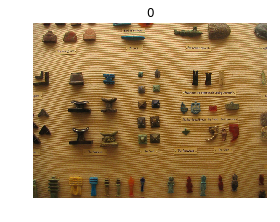

In [4]:
BS=1
NUM_WORKERS=8
tfms = get_transforms(do_flip=False)
tfms = (tfms[1],tfms[1]) #no transforms
data = (ImageList.from_df(df,'', cols=['Image'])
        .split_none()
        .label_const()
        .transform(tfms, resize_method=ResizeMethod.NO)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats)
       ) 
data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
data.train_dl.dl.batch_sampler.drop_last = False
#No shuffle
data.show_batch()

In [5]:
from arch import GeM, L2Norm
class GeMNet(nn.Module):
    def __init__(self, new_model):
        super().__init__()
        self.cnn =  new_model.features
        self.head = nn.Sequential(nn.ReLU(),
                                  GeM(3.0),
                                  Flatten(),
                                  L2Norm())
    def forward(self, x):
        x = self.cnn(x)
        out = self.head(x)
        return out
InferenceNet =  GeMNet(models.densenet121(pretrained=True))
OUT_DIM = 1024

In [6]:
#We will extract database descriptors, then query descriptors and then calculate mean average precision (mAP)
from fastprogress import master_bar, progress_bar
def extract_vectors(data,model):
    model.cuda()
    model.eval()
    with torch.no_grad():
        vectors = torch.zeros(len(data.train_dl), OUT_DIM).cpu()
        idx=0
        for img_label in progress_bar(data.train_dl):
            img,label = img_label
            vectors[idx,:] = model(img).cpu()
            idx+=1
    return vectors
db_vectors = extract_vectors(data,InferenceNet)

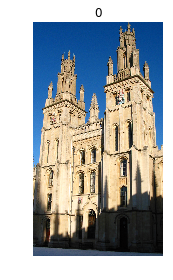

In [7]:
def open_image_cropped(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image)->Image:
    "Return `Image` object created from image in file `fn`."
    #fn = getattr(fn, 'path', fn)
    x = PIL.Image.open(fn).convert(convert_mode).crop(bbxs[str(fn).replace('./','')])
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

class ImageItemCrop(ImageList):
    def open(self, fn:PathOrStr)->Image:
        return open_image_cropped(fn)
BS=1
NUM_WORKERS=8
tfms = get_transforms(do_flip=False)
tfms = (tfms[1],tfms[1]) #no transforms

query_data = (ImageItemCrop.from_df(qdf,'', cols=['qimages'])
        .split_none()
        .label_const()
        .transform(tfms, resize_method=ResizeMethod.NO)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats)
       ) 
query_data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(query_data.train_ds)
query_data.train_dl.dl.batch_sampler.drop_last = False
#No shuffle
query_data.show_batch()

In [8]:
query_vectors = extract_vectors(query_data,InferenceNet)

In [9]:
print('>> {}: Evaluating...'.format(dataset))
# convert to numpy
vecs = db_vectors.numpy()
qvecs = query_vectors.numpy()
# search, rank, and print
scores = np.dot(vecs, qvecs.T)
ranks = np.argsort(-scores, axis=0)
compute_map_and_print(dataset, ranks, cfg['gnd'])


>> oxford5k: Evaluating...
>> oxford5k: mAP 41.62


It is very far from the state-of-the-art, but we got fast network and haven`t trained it at all.
Lets make a submission 